# 贝叶斯回归

## 贝叶斯岭回归的简单例子

In [9]:
from sklearn import linear_model
clf = linear_model.BayesianRidge()
clf.fit([[0,0], [1, 1], [2, 2]], [0, 1, 2])
clf.predict([[1, 1]])

array([1.])

## 贝叶斯岭回归拟合曲线

In [10]:
# Author: Yoshihiro Uchida <nimbus1after2a1sun7shower@gmail.com>

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [11]:
# 定义真实曲线函数：正弦曲线
def func(x): return np.sin(2*np.pi*x)
# 生成带噪音的正弦曲线
size = 25
rng = np.random.RandomState(1234)
# 均匀分布
x_train = rng.uniform(0., 1., size)
# 残差是高斯分布
y_train = func(x_train) + rng.normal(scale=0.1, size=size)
x_test = np.linspace(0., 1., 100)

# 使用三阶多项式来拟合
n_order = 3
# 使用单个x值，生成X矩阵，生成范特蒙德矩阵
X_train = np.vander(x_train, n_order + 1, increasing=True)
X_test = np.vander(x_test, n_order + 1, increasing=True)

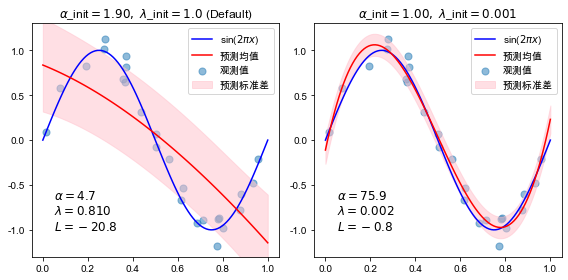

In [12]:
# 作图
reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, ax in enumerate(axes):
    # Bayesian ridge regression with different initial value pairs
    if i == 0:
        # 计算方差
        init = [1 / np.var(y_train), 1.]  # Default values
    elif i == 1:
        init = [1., 1e-3]
        reg.set_params(alpha_init=init[0], lambda_init=init[1])
    reg.fit(X_train, y_train)
    ymean, ystd = reg.predict(X_test, return_std=True)

    ax.plot(x_test, func(x_test), color="blue", label="sin($2\\pi x$)")
    ax.scatter(x_train, y_train, s=50, alpha=0.5, label="观测值")
    ax.plot(x_test, ymean, color="red", label="预测均值")
    ax.fill_between(x_test, ymean-ystd, ymean+ystd,
                    color="pink", alpha=0.5, label="预测标准差")
    ax.set_ylim(-1.3, 1.3)
    ax.legend()
    title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(
            init[0], init[1])
    if i == 0:
        title += " (Default)"
    ax.set_title(title, fontsize=12)
    text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
           reg.alpha_, reg.lambda_, reg.scores_[-1])
    ax.text(0.05, -1.0, text, fontsize=12)

plt.tight_layout()
plt.show()


## 贝叶斯回归的更加复杂的应用

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.linear_model import BayesianRidge, LinearRegression

# #############################################################################
# Generating simulated data with Gaussian weights
np.random.seed(0)
n_samples, n_features = 100, 100
X = np.random.randn(n_samples, n_features)  # Create Gaussian data
# Create weights with a precision lambda_ of 4.
lambda_ = 4.
w = np.zeros(n_features)
# Only keep 10 weights of interest
relevant_features = np.random.randint(0, n_features, 10)
for i in relevant_features:
    w[i] = stats.norm.rvs(loc=0, scale=1. / np.sqrt(lambda_))
# Create noise with a precision alpha of 50.
alpha_ = 50.
noise = stats.norm.rvs(loc=0, scale=1. / np.sqrt(alpha_), size=n_samples)
# Create the target
y = np.dot(X, w) + noise

# #############################################################################
# Fit the Bayesian Ridge Regression and an OLS for comparison
clf = BayesianRidge(compute_score=True)
clf.fit(X, y)

ols = LinearRegression()
ols.fit(X, y)

# #############################################################################
# Plot true weights, estimated weights, histogram of the weights, and
# predictions with standard deviations
lw = 2
plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(clf.coef_, color='lightgreen', linewidth=lw,
         label="Bayesian Ridge estimate")
plt.plot(w, color='gold', linewidth=lw, label="Ground truth")
plt.plot(ols.coef_, color='navy', linestyle='--', label="OLS estimate")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc="best", prop=dict(size=12))

plt.figure(figsize=(6, 5))
plt.title("Histogram of the weights")
plt.hist(clf.coef_, bins=n_features, color='gold', log=True,
         edgecolor='black')
plt.scatter(clf.coef_[relevant_features], np.full(len(relevant_features), 5.),
            color='navy', label="Relevant features")
plt.ylabel("Features")
plt.xlabel("Values of the weights")
plt.legend(loc="upper left")

plt.figure(figsize=(6, 5))
plt.title("Marginal log-likelihood")
plt.plot(clf.scores_, color='navy', linewidth=lw)
plt.ylabel("Score")
plt.xlabel("Iterations")


# Plotting some predictions for polynomial regression
def f(x, noise_amount):
    y = np.sqrt(x) * np.sin(x)
    noise = np.random.normal(0, 1, len(x))
    return y + noise_amount * noise


degree = 10
X = np.linspace(0, 10, 100)
y = f(X, noise_amount=0.1)
clf_poly = BayesianRidge()
clf_poly.fit(np.vander(X, degree), y)

X_plot = np.linspace(0, 11, 25)
y_plot = f(X_plot, noise_amount=0)
y_mean, y_std = clf_poly.predict(np.vander(X_plot, degree), return_std=True)
plt.figure(figsize=(6, 5))
plt.errorbar(X_plot, y_mean, y_std, color='navy',
             label="Polynomial Bayesian Ridge Regression", linewidth=lw)
plt.plot(X_plot, y_plot, color='gold', linewidth=lw,
         label="Ground Truth")
plt.ylabel("Output y")
plt.xlabel("Feature X")
plt.legend(loc="lower left")
plt.show()